<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/synthetic_data_generation_1113.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [132]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [133]:
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
import random

data_x = {}
weight = {}
errors = []
for f in range(10):
    data_x[f'x{f}'] = []
    weight[f'w{f}'] = []
    d1 = random.uniform(0.5, 10.0)
    d2 = random.uniform(0.0, 0.001)
    d3 = random.uniform(0.0, 0.003)
    w = random.uniform(0, 5)
    w_delta = random.uniform(-0.003, 0.001)
    for i in range(1000):
        for j in range(10):
            data_x[f'x{f}'].extend(np.random.normal(d1+(i*d2),2.0+(i*d3),100))
            weight[f'w{f}'].extend(w + (w_delta*i)+np.random.normal(0.0,0.01,100))
            #weight[f'w{f}'].extend(w + np.random.normal(0.0,0.01,100))

for i in range(10000):        
    errors.extend(np.random.normal(1.0,10.0,100))

dataset = pd.DataFrame(data_x)
importance = pd.DataFrame(weight)

y=np.sum(np.multiply(importance.values,dataset.values),axis=1) + np.asarray(errors)

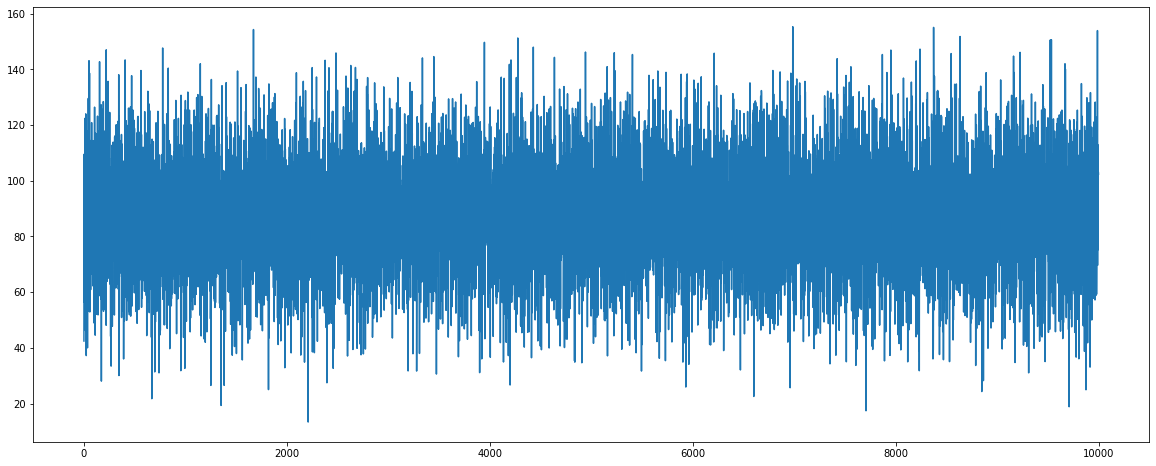

In [5]:
plt.figure(figsize=(20,8))
plt.plot(y[0:10000])

In [6]:
dataset['y'] = [1 if i > 60 else 0 for i in y]

In [7]:
dataset

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,5.540840,0.469440,5.994303,-2.509596,-3.471999,1.643670,3.502036,9.161094,5.681789,6.179650,0
1,9.366255,1.143275,-0.998187,3.274898,2.371543,1.096213,5.586931,5.416070,4.661443,7.960840,1
2,8.557846,2.651659,1.043919,0.565038,0.607315,3.962718,1.424855,5.574354,3.480819,4.704206,0
3,4.835298,2.163853,2.015219,3.628032,5.436487,2.025114,4.361402,7.410087,8.000015,3.409515,1
4,6.815571,-1.078886,3.661938,0.271840,0.203101,1.784145,3.848940,7.221731,7.480078,4.113948,1
...,...,...,...,...,...,...,...,...,...,...,...
999995,11.010777,4.315886,-0.788396,-5.192932,-0.269090,2.598519,-3.213489,6.782540,6.744794,3.886025,0
999996,15.226904,2.236243,6.643918,-2.691103,-2.455142,-0.119680,3.715849,5.692961,6.585795,10.160121,0
999997,13.103412,-3.027444,8.294496,0.270380,2.717650,4.084132,1.770805,5.713459,8.547056,4.286854,0
999998,5.202382,5.915719,4.204388,1.894984,-1.143589,6.500011,5.957249,13.530772,6.984854,3.407481,1


In [138]:
dataset.to_csv('/content/drive/MyDrive/laos/synthetic_dataset_1_1113.csv')

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
trainset = dataset[0:10000].drop(columns=['y']).values
train_y = dataset[0:10000]['y'].values

In [10]:
business_model = RandomForestClassifier(n_estimators=80,max_depth=5)
business_model.fit(trainset,train_y)

RandomForestClassifier(max_depth=5, n_estimators=80)

In [11]:
testset = dataset[10000:14000].drop(columns=['y']).values
test_y = dataset[10000:14000]['y'].values

In [12]:
from sklearn.metrics import precision_recall_fscore_support

base_score = precision_recall_fscore_support(test_y, business_model.predict(testset),average='binary')

In [13]:
base_score

(0.9162685441287403, 0.9994514536478333, 0.9560540469631379, None)

In [124]:

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [15]:
X2 = dataset[14000:].drop(columns=['y']).values
Y2 = dataset[14000:]['y'].values

In [114]:
import math

result = {}
result['precision'] = []
result['predicted'] = []
result['drift'] = []
window_size = 10000
step = 5000
predicted = 0
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size]
    uy = Y2[i*step:i*step+window_size]
    f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')
    drift = __ks_drift(trainset,ux)
    result['precision'].append(f1[0])
    result['predicted'].append(0.0)
    result['drift'].append(sum(abs(drift[:,0])))

In [115]:
result_df = pd.DataFrame(result)

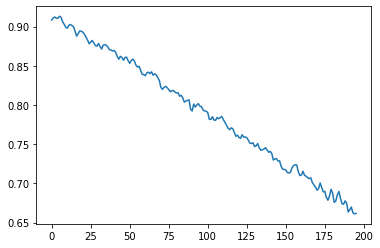

In [116]:
result_df['precision'].plot()

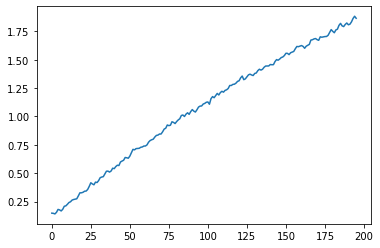

In [117]:
result_df['drift'].plot()

In [20]:
false_x = []
true_x = []

y_hat = business_model.predict(testset)

inx = 0
for yt,yp in zip(test_y,y_hat):
    if yt == yp:
        true_x.append(np.append(testset[inx],yt))
    else:
        false_x.append(np.append(testset[inx],yt))
    inx = inx + 1

true_x = np.asarray(true_x)
false_x = np.asarray(false_x)

In [21]:
false_x.shape

(335, 11)

In [125]:
import statsmodels.api as sm

def ppm_build(scale = 10.0,epoch =1000):
    scores = []
    drifts = []
    test_result = {}
    base = base_score[0]*100
    perf = np.random.normal(loc=base, scale=scale, size=epoch) 
    perf = np.asarray([c if c < base else base*2 - c for c in perf]) /100
    for i in range(epoch):
        tx = true_x[np.random.choice(true_x.shape[0], int((perf[i] * false_x.shape[0]) /(1 - perf[i])), replace=True),:]
        fx = false_x #np.random.permutation(false_x)[0:np.random.randint(1,false_x.shape[0],1)[0]]
        #fx = np.random.permutation(false_x)[0:np.random.randint(1,false_x.shape[0],1)[0]]
        #tx = true_x[np.random.choice(true_x.shape[0], fx.shape[0] * ratio, replace=True)[0:np.random.randint(1,fx.shape[0] * ratio,1)[0]],:]
        ffx = np.concatenate((tx,fx))
        np.random.shuffle(ffx)
        tx = ffx[:,0:10]
        ty = ffx[:,10]
        f1 = precision_recall_fscore_support(ty, business_model.predict(tx),average='binary')
        #x_ref2 = np.random.permutation(x_ref)[0:tx.shape[0]]
        drift = __ks_drift(trainset[np.random.choice(trainset.shape[0],tx.shape[0], replace=False),:],tx)
        #drift = __ks_drift(trainset,tx)
        scores.append(f1[0])
        drifts.append(np.append(drift[:,0],1))
        print(f"\r{i+1}/{epoch} precision:{f1[0]:.4f} drift:{drift[0,0]:.4f}", end="", flush=True)

    test_result['precision'] = scores
    drifts = np.asarray(drifts)
    for i in range(10):
        test_result[f'd{i}'] = drifts[:,i]

    plt.hist(scores, bins = 100)
    plt.show()

    model = sm.OLS(scores, drifts).fit()
    print('Model R^2:',model.rsquared)
    print(model.summary())
    return model, pd.DataFrame(test_result)

1000/1000 precision:0.7852 drift:0.0403

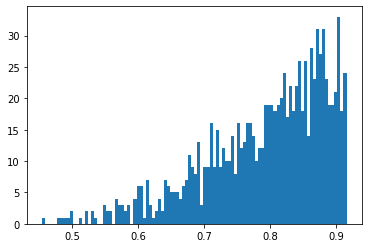

Model R^2: 0.9644982264188018
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     2687.
Date:                Sun, 13 Nov 2022   Prob (F-statistic):               0.00
Time:                        06:52:47   Log-Likelihood:                 2629.1
No. Observations:                1000   AIC:                            -5236.
Df Residuals:                     989   BIC:                            -5182.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3102 

In [129]:
ppmodel,df_test_result = ppm_build(scale = 15,epoch =1000)

In [94]:
df_test_result

,precision,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9
0,0.871874,0.028309,0.045907,0.039403,0.054323,0.011477,0.030987,0.031752,0.047437,0.020275,0.024101
1,0.824737,0.026688,0.050759,0.047096,0.063318,0.054945,0.052852,0.046049,0.053898,0.034537,0.021455
2,0.787220,0.045831,0.036919,0.038829,0.093571,0.034373,0.029917,0.052833,0.056015,0.038192,0.031827
3,0.678261,0.052834,0.112392,0.037464,0.071085,0.091258,0.030740,0.062440,0.096061,0.059558,0.041306
4,0.893542,0.027397,0.020389,0.028672,0.028353,0.018159,0.023574,0.043326,0.032176,0.035043,0.016566
...,...,...,...,...,...,...,...,...,...,...,...
95,0.812921,0.026816,0.068156,0.040782,0.083240,0.065363,0.034078,0.034078,0.041899,0.026816,0.043017
96,0.849389,0.022890,0.048923,0.033662,0.053411,0.021544,0.032765,0.044883,0.042639,0.030072,0.031418
97,0.774390,0.020904,0.071477,0.041133,0.060688,0.047876,0.047876,0.073500,0.066082,0.026298,0.066757
98,0.907884,0.015397,0.028320,0.014023,0.036294,0.023646,0.027770,0.021446,0.020621,0.025571,0.033544


In [95]:
df_test_result2= df_test_result.sort_values(by=['precision'])
df_test_result2 = df_test_result2.reset_index()
df_test_result2 = df_test_result2.drop(columns=['index'])

In [96]:
df_test_result2

,precision,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9
0,0.670297,0.024655,0.135108,0.050296,0.078895,0.106509,0.039448,0.060158,0.091716,0.039448,0.059172
1,0.676699,0.027992,0.106178,0.029923,0.098456,0.107143,0.017375,0.092664,0.055985,0.050193,0.047297
2,0.678261,0.052834,0.112392,0.037464,0.071085,0.091258,0.030740,0.062440,0.096061,0.059558,0.041306
3,0.682857,0.029218,0.094251,0.028275,0.081056,0.104618,0.024505,0.082941,0.091423,0.044298,0.074458
4,0.699187,0.028751,0.103324,0.060198,0.091644,0.076370,0.027853,0.079964,0.088050,0.044025,0.083558
...,...,...,...,...,...,...,...,...,...,...,...
95,0.911436,0.018499,0.028277,0.024577,0.044133,0.025106,0.028541,0.019027,0.022199,0.027220,0.014799
96,0.911951,0.031742,0.021773,0.028332,0.058499,0.020199,0.029906,0.024921,0.013379,0.023610,0.033054
97,0.913168,0.020466,0.020466,0.012694,0.026684,0.016321,0.022539,0.013212,0.031347,0.018135,0.023316
98,0.914153,0.020236,0.021516,0.016650,0.030994,0.012807,0.024846,0.017930,0.020236,0.020236,0.031506


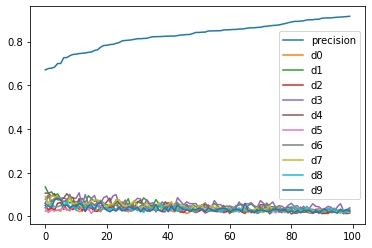

In [97]:
df_test_result2.plot()

In [127]:
from sklearn.metrics import r2_score

def test1(model2):
    result = {}
    result['precision'] = []
    result['predicted'] = []
    window_size = 100000
    step = 5000
    predicted = 0
    batch = math.ceil((X2.shape[0]-window_size)/step)
    for i in range(batch):
        ux = X2[i*step:i*step+window_size]
        uy = Y2[i*step:i*step+window_size]
        f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')

        drift = __ks_drift(trainset,ux)
        precision = f1[0]
        predicted1 = model2.predict(np.append(drift[:,0],1))[0]
        if abs(predicted1-predicted) > 0.1 and predicted > 0:
            predicted1 = predicted
        result['precision'].append(precision)
        result['predicted'].append(predicted1)
        print(f"\r{i+1}/{batch} precision:{precision:.4f} predicted:{predicted1:.4f} drift:{drift[1,0]}", end="", flush=True)
        predicted = predicted1

    R2 = r2_score(result['precision'],result['predicted'])
    print('')
    print('R2:',R2)
    result_df = pd.DataFrame(result)
    result_df.plot()
    plt.show()
    return R2, result_df

In [142]:
def result_visualization(Exp,scale,df3,result_data):
    for key, value in result_data.items():
        mean = np.mean(value)
        error_rate = 1.96 * np.std(value) / math.sqrt(len(result_data))
        print(f'{key}:{mean:.4f} +- {error_rate:.4f}')

    df4 = pd.DataFrame(df3)
    colums = []
    for trial in result_data['Trial']:
        colums.append(f'predicted {trial}')

    mean_r_2 = np.mean(result_data['R2'])
    print('Mean R^2 (sum(r2)/N) :',mean_r_2)
    df4['max predicted precision'] = df4[colums].max(axis=1)
    df4['mean predicted precision'] = df4[colums].mean(axis=1)
    df4['min predicted precision'] = df4[colums].min(axis=1)

    mean_r_2 = r2_score(df4['real precision'],df4['mean predicted precision'])

    df4[['real precision','mean predicted precision']].plot(title=f'Exp:{Exp+1}, sampling_scale:{scale}, Mean R^2:{mean_r_2:.4f}', figsize=(8,8))
    plt.fill_between(df4.index, df4['max predicted precision'].values, df4['min predicted precision'].values, alpha=0.40, color='tab:blue')
    plt.show()

178/178 precision:0.6752 predicted:0.1990 drift:0.23299000000000003
R2: -20.014182311658132


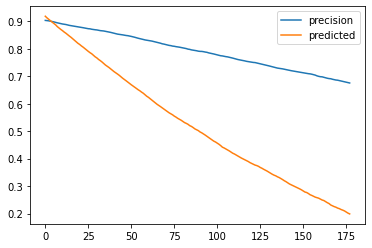

In [130]:
R2, result_df = test1(ppmodel)

Exp 1, Trial 1
1000/1000 precision:0.9129 drift:0.0283

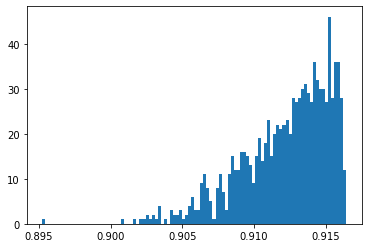

Model R^2: 0.05207089448772739
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     5.433
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           7.13e-08
Time:                        13:45:12   Log-Likelihood:                 4384.8
No. Observations:                1000   AIC:                            -8748.
Df Residuals:                     989   BIC:                            -8694.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0483

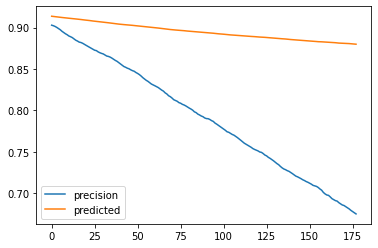

Exp 1, Trial 2
1000/1000 precision:0.9115 drift:0.0177

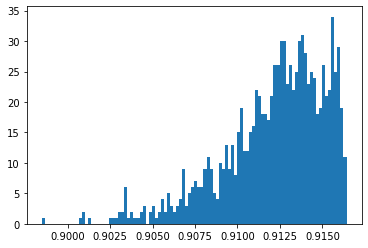

Model R^2: 0.05641819790875546
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     5.913
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.00e-08
Time:                        13:48:41   Log-Likelihood:                 4409.4
No. Observations:                1000   AIC:                            -8797.
Df Residuals:                     989   BIC:                            -8743.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0331

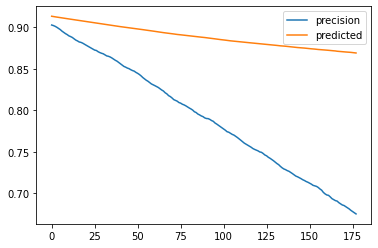

Exp 1, Trial 3
1000/1000 precision:0.9142 drift:0.0174

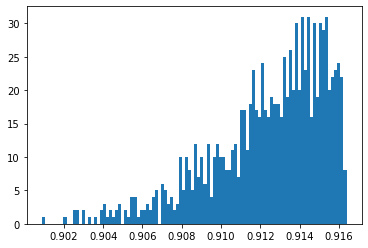

Model R^2: 0.0920072006296363
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     10.02
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           3.69e-16
Time:                        13:52:11   Log-Likelihood:                 4465.4
No. Observations:                1000   AIC:                            -8909.
Df Residuals:                     989   BIC:                            -8855.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0478 

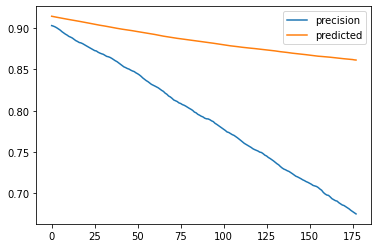

Exp 1, Trial 4
1000/1000 precision:0.9137 drift:0.0232

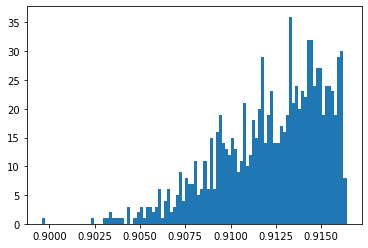

Model R^2: 0.09415193480307682
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     10.28
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.26e-16
Time:                        13:55:40   Log-Likelihood:                 4470.9
No. Observations:                1000   AIC:                            -8920.
Df Residuals:                     989   BIC:                            -8866.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0308

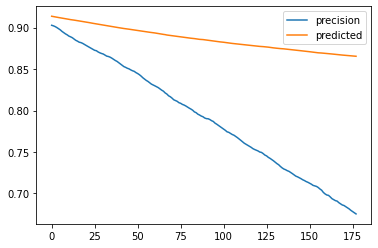

Exp 1, Trial 5
1000/1000 precision:0.9082 drift:0.0194

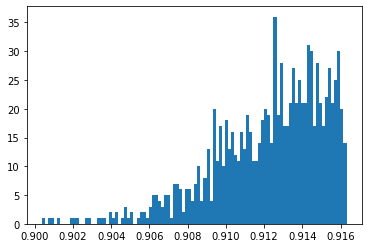

Model R^2: 0.04303820717153384
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     4.448
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           3.75e-06
Time:                        13:59:10   Log-Likelihood:                 4442.6
No. Observations:                1000   AIC:                            -8863.
Df Residuals:                     989   BIC:                            -8809.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0235

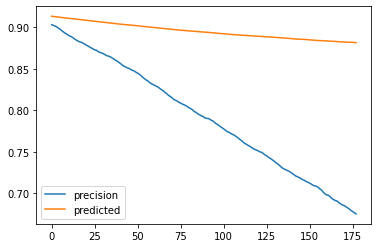

R2:-1.8743 +- 0.3446
Trial:2.0000 +- 1.9600
Mean R^2 (sum(r2)/N) : -1.8742971910059059


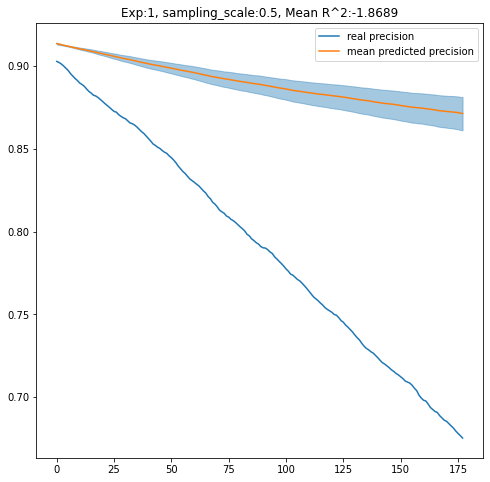

Exp 2, Trial 1
1000/1000 precision:0.9112 drift:0.0222

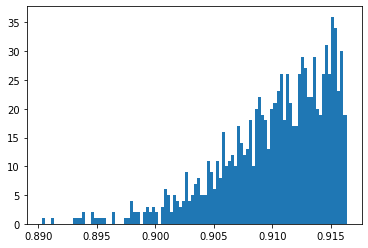

Model R^2: 0.13037605810868647
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     14.83
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           7.75e-25
Time:                        14:02:44   Log-Likelihood:                 4018.0
No. Observations:                1000   AIC:                            -8014.
Df Residuals:                     989   BIC:                            -7960.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0763

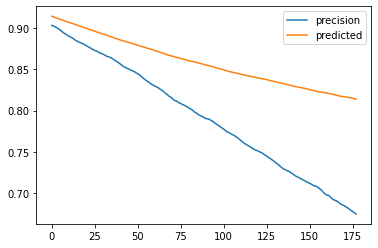

Exp 2, Trial 2
1000/1000 precision:0.9161 drift:0.0198

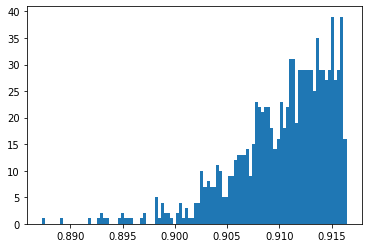

Model R^2: 0.10011542956789343
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     11.00
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           6.09e-18
Time:                        14:06:15   Log-Likelihood:                 4017.0
No. Observations:                1000   AIC:                            -8012.
Df Residuals:                     989   BIC:                            -7958.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0509

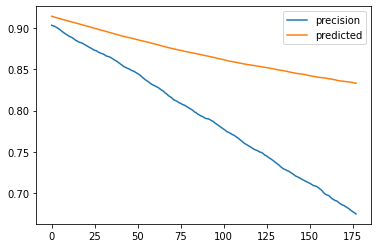

Exp 2, Trial 3
1000/1000 precision:0.9137 drift:0.0222

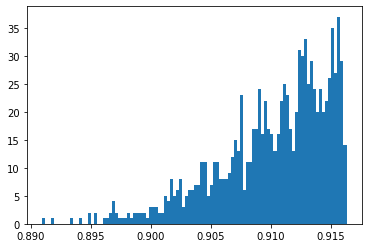

Model R^2: 0.1355782236097849
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     15.51
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           4.65e-26
Time:                        14:09:49   Log-Likelihood:                 4017.5
No. Observations:                1000   AIC:                            -8013.
Df Residuals:                     989   BIC:                            -7959.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0337 

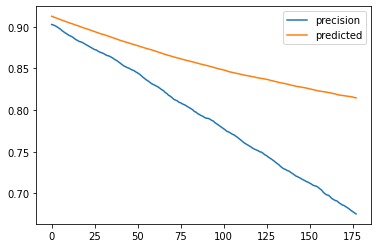

Exp 2, Trial 4
1000/1000 precision:0.9061 drift:0.0264

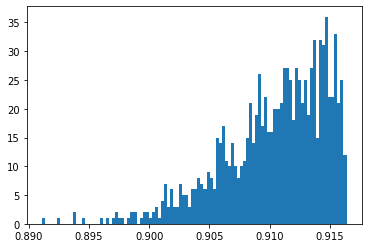

Model R^2: 0.08733557322108731
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     9.464
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           3.81e-15
Time:                        14:13:22   Log-Likelihood:                 4070.4
No. Observations:                1000   AIC:                            -8119.
Df Residuals:                     989   BIC:                            -8065.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0719

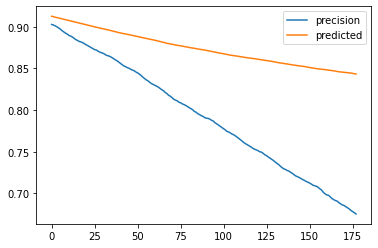

Exp 2, Trial 5
1000/1000 precision:0.9143 drift:0.0207

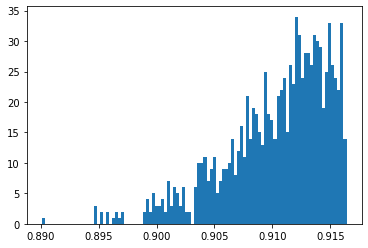

Model R^2: 0.08674690869197699
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     9.394
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           5.11e-15
Time:                        14:16:55   Log-Likelihood:                 4042.5
No. Observations:                1000   AIC:                            -8063.
Df Residuals:                     989   BIC:                            -8009.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0529

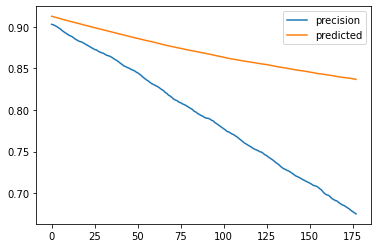

R2:-0.6691 +- 0.3988
Trial:2.0000 +- 1.9600
Mean R^2 (sum(r2)/N) : -0.6690551797031932


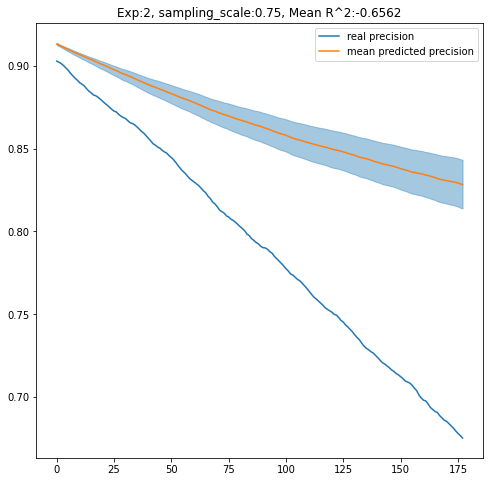

Exp 3, Trial 1
1000/1000 precision:0.9108 drift:0.0154

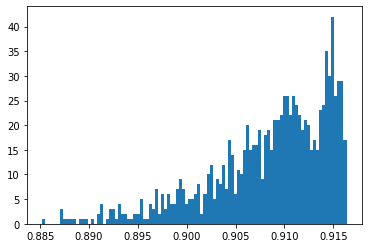

Model R^2: 0.2086737630472656
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     26.08
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           2.71e-44
Time:                        14:20:27   Log-Likelihood:                 3787.0
No. Observations:                1000   AIC:                            -7552.
Df Residuals:                     989   BIC:                            -7498.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0457 

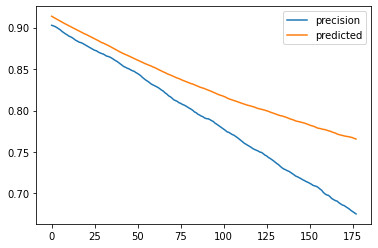

Exp 3, Trial 2
1000/1000 precision:0.8939 drift:0.0187

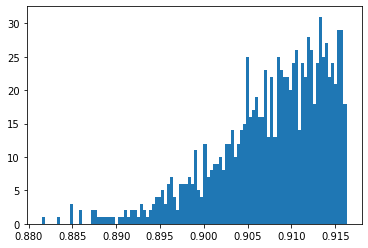

Model R^2: 0.1772450190890269
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     21.31
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           3.29e-36
Time:                        14:23:57   Log-Likelihood:                 3727.2
No. Observations:                1000   AIC:                            -7432.
Df Residuals:                     989   BIC:                            -7378.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0777 

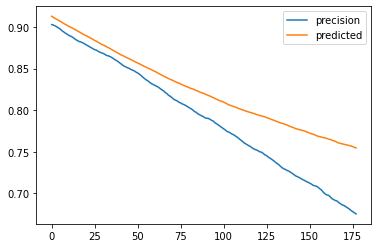

Exp 3, Trial 3
1000/1000 precision:0.9021 drift:0.0173

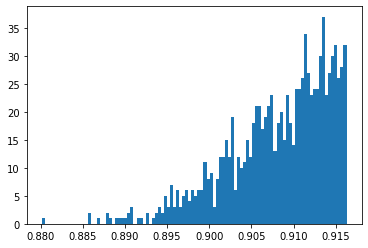

Model R^2: 0.16871770725276225
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     20.07
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           4.44e-34
Time:                        14:27:29   Log-Likelihood:                 3763.0
No. Observations:                1000   AIC:                            -7504.
Df Residuals:                     989   BIC:                            -7450.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0888

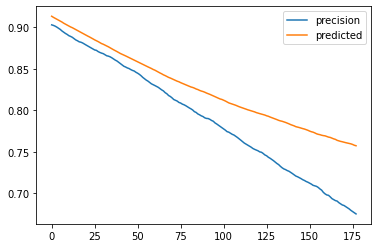

Exp 3, Trial 4
1000/1000 precision:0.9101 drift:0.0287

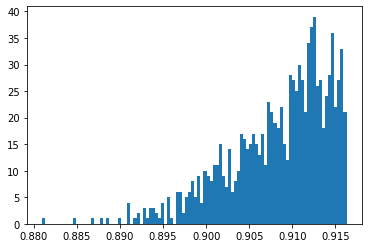

Model R^2: 0.1727800262376119
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     20.66
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           4.32e-35
Time:                        14:30:59   Log-Likelihood:                 3818.0
No. Observations:                1000   AIC:                            -7614.
Df Residuals:                     989   BIC:                            -7560.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1004 

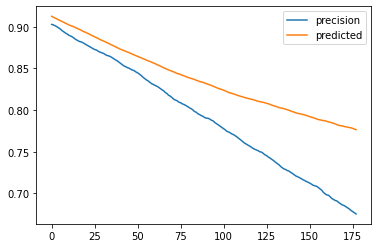

Exp 3, Trial 5
1000/1000 precision:0.9050 drift:0.0215

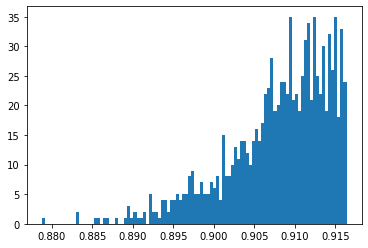

Model R^2: 0.21303375956424575
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     26.77
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.92e-45
Time:                        14:34:30   Log-Likelihood:                 3765.7
No. Observations:                1000   AIC:                            -7509.
Df Residuals:                     989   BIC:                            -7455.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1279

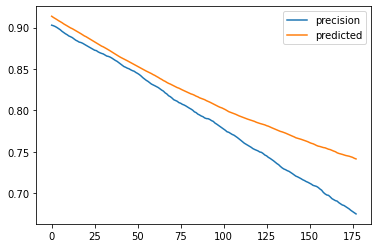

R2:0.5797 +- 0.1891
Trial:2.0000 +- 1.9600
Mean R^2 (sum(r2)/N) : 0.5796918919643057


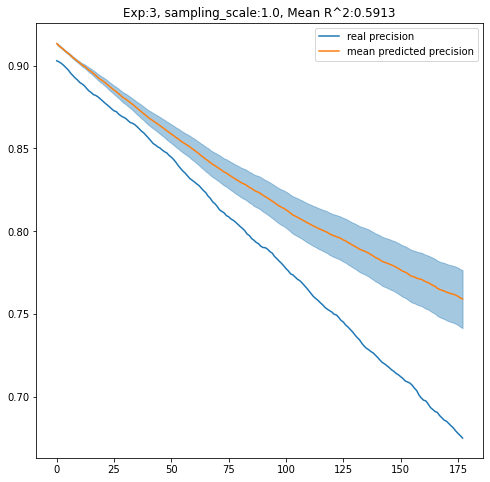

Exp 4, Trial 1
1000/1000 precision:0.9141 drift:0.0198

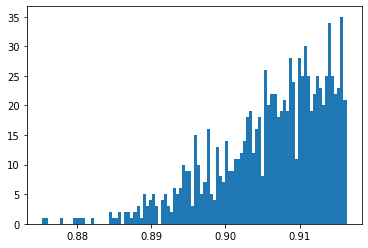

Model R^2: 0.24949688736148956
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     32.88
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           2.32e-55
Time:                        14:38:02   Log-Likelihood:                 3603.9
No. Observations:                1000   AIC:                            -7186.
Df Residuals:                     989   BIC:                            -7132.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1992

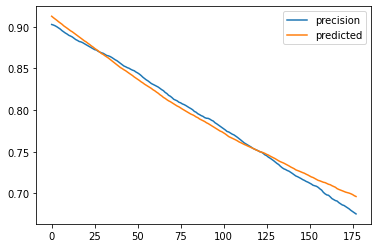

Exp 4, Trial 2
1000/1000 precision:0.9159 drift:0.0211

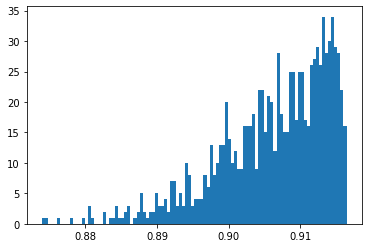

Model R^2: 0.22208962658236897
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     28.24
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           7.39e-48
Time:                        14:41:32   Log-Likelihood:                 3556.7
No. Observations:                1000   AIC:                            -7091.
Df Residuals:                     989   BIC:                            -7037.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1626

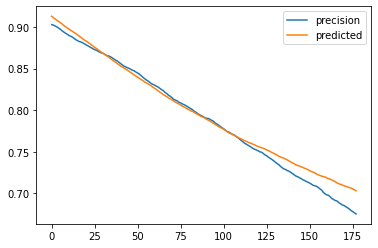

Exp 4, Trial 3
1000/1000 precision:0.8971 drift:0.0356

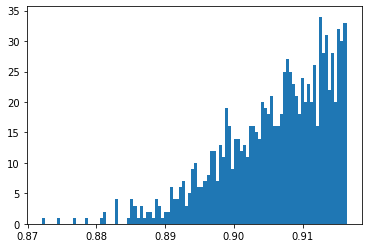

Model R^2: 0.23546158470903655
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     30.46
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.76e-51
Time:                        14:45:04   Log-Likelihood:                 3567.0
No. Observations:                1000   AIC:                            -7112.
Df Residuals:                     989   BIC:                            -7058.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1293

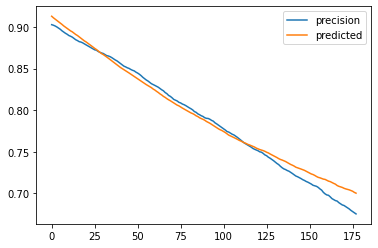

Exp 4, Trial 4
1000/1000 precision:0.8994 drift:0.0204

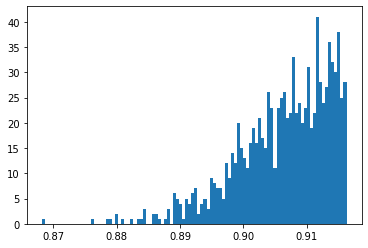

Model R^2: 0.2413840724875832
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     31.47
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           4.15e-53
Time:                        14:48:35   Log-Likelihood:                 3617.4
No. Observations:                1000   AIC:                            -7213.
Df Residuals:                     989   BIC:                            -7159.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1438 

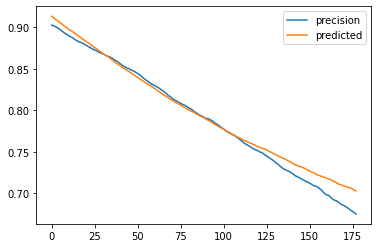

Exp 4, Trial 5
1000/1000 precision:0.9157 drift:0.0179

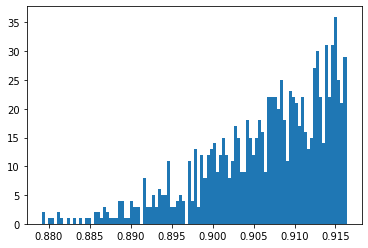

Model R^2: 0.24772446315632157
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     32.57
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           7.25e-55
Time:                        14:52:06   Log-Likelihood:                 3603.2
No. Observations:                1000   AIC:                            -7184.
Df Residuals:                     989   BIC:                            -7130.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1696

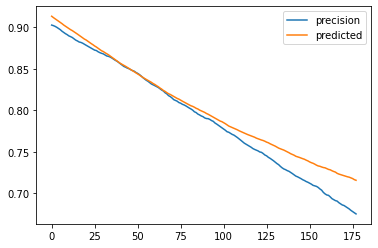

R2:0.9714 +- 0.0240
Trial:2.0000 +- 1.9600
Mean R^2 (sum(r2)/N) : 0.9714009532873996


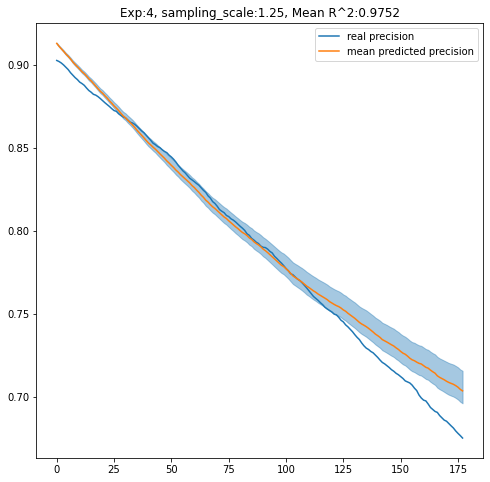

Exp 5, Trial 1
1000/1000 precision:0.9106 drift:0.0197

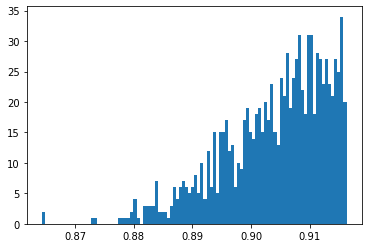

Model R^2: 0.29674578136565344
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     41.73
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           5.01e-69
Time:                        14:55:36   Log-Likelihood:                 3477.6
No. Observations:                1000   AIC:                            -6933.
Df Residuals:                     989   BIC:                            -6879.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1711

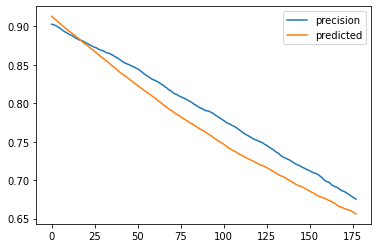

Exp 5, Trial 2
1000/1000 precision:0.9080 drift:0.0206

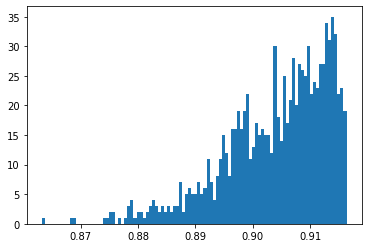

Model R^2: 0.33828684700661515
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     50.56
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           7.09e-82
Time:                        14:59:07   Log-Likelihood:                 3482.1
No. Observations:                1000   AIC:                            -6942.
Df Residuals:                     989   BIC:                            -6888.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1611

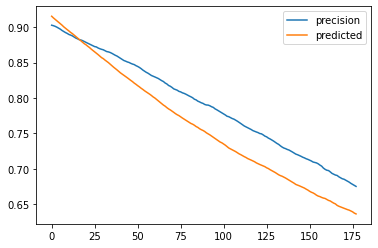

Exp 5, Trial 3
1000/1000 precision:0.8898 drift:0.0349

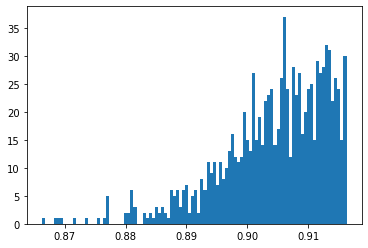

Model R^2: 0.286666595130626
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     39.74
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           4.97e-66
Time:                        15:02:39   Log-Likelihood:                 3485.6
No. Observations:                1000   AIC:                            -6949.
Df Residuals:                     989   BIC:                            -6895.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0953  

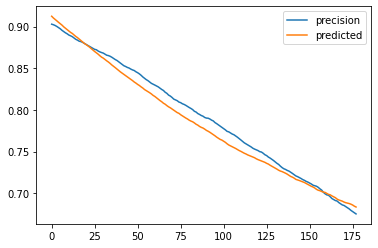

Exp 5, Trial 4
1000/1000 precision:0.8911 drift:0.0202

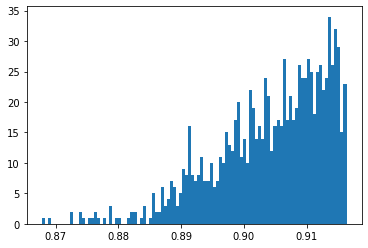

Model R^2: 0.2893286920715431
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     40.26
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           8.12e-67
Time:                        15:06:10   Log-Likelihood:                 3467.9
No. Observations:                1000   AIC:                            -6914.
Df Residuals:                     989   BIC:                            -6860.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1053 

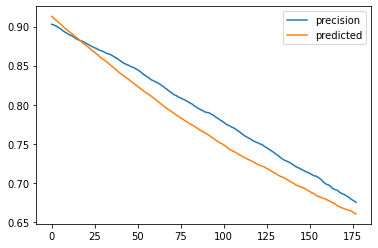

Exp 5, Trial 5
1000/1000 precision:0.9158 drift:0.0193

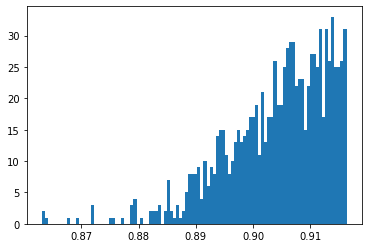

Model R^2: 0.31219110320680643
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     44.89
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.04e-73
Time:                        15:09:41   Log-Likelihood:                 3474.4
No. Observations:                1000   AIC:                            -6927.
Df Residuals:                     989   BIC:                            -6873.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1140

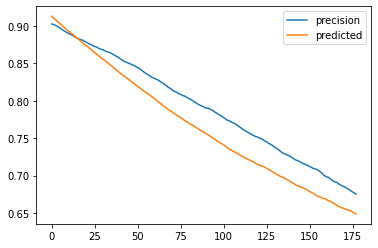

R2:0.8580 +- 0.1145
Trial:2.0000 +- 1.9600
Mean R^2 (sum(r2)/N) : 0.8579648715617199


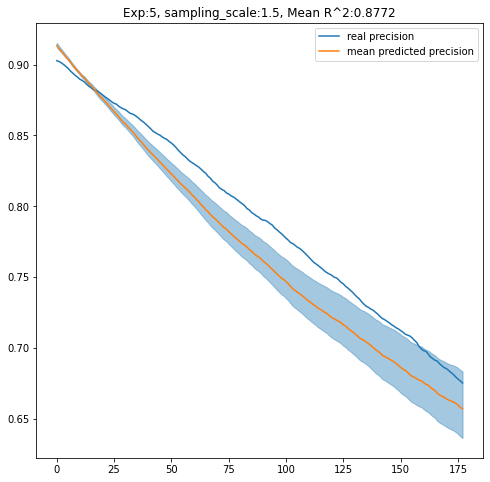

Exp 6, Trial 1
1000/1000 precision:0.9041 drift:0.0218

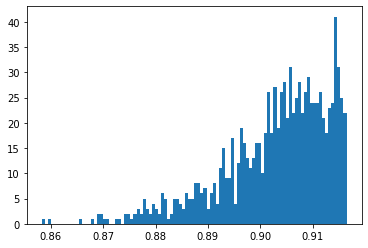

Model R^2: 0.37414235728963996
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     59.12
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.15e-93
Time:                        15:13:11   Log-Likelihood:                 3393.3
No. Observations:                1000   AIC:                            -6765.
Df Residuals:                     989   BIC:                            -6711.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1794

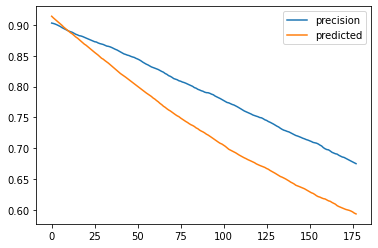

Exp 6, Trial 2
1000/1000 precision:0.9048 drift:0.0319

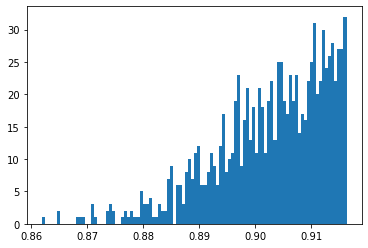

Model R^2: 0.3728726319543756
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     58.80
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           3.09e-93
Time:                        15:16:41   Log-Likelihood:                 3403.7
No. Observations:                1000   AIC:                            -6785.
Df Residuals:                     989   BIC:                            -6732.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2979 

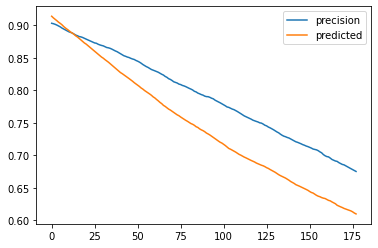

Exp 6, Trial 3
1000/1000 precision:0.9025 drift:0.0245

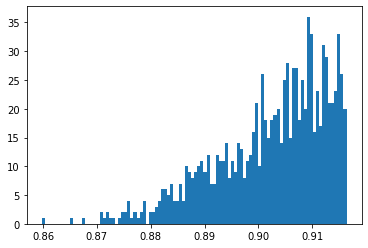

Model R^2: 0.36240860869060465
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     56.22
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           9.87e-90
Time:                        15:20:13   Log-Likelihood:                 3380.4
No. Observations:                1000   AIC:                            -6739.
Df Residuals:                     989   BIC:                            -6685.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1599

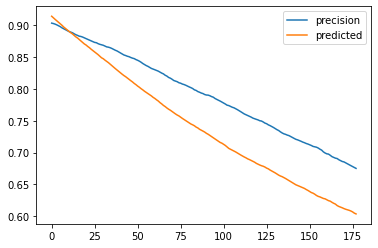

Exp 6, Trial 4
1000/1000 precision:0.8910 drift:0.0186

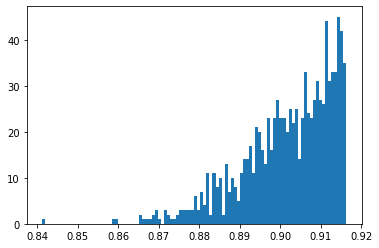

Model R^2: 0.3566912428868029
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     54.84
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           7.66e-88
Time:                        15:23:44   Log-Likelihood:                 3287.4
No. Observations:                1000   AIC:                            -6553.
Df Residuals:                     989   BIC:                            -6499.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2282 

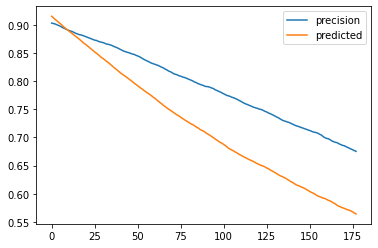

Exp 6, Trial 5
1000/1000 precision:0.8915 drift:0.0250

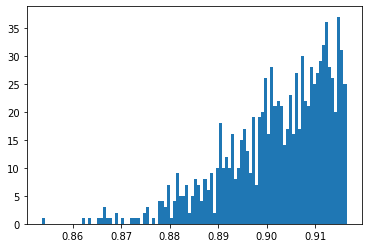

Model R^2: 0.35833996597083584
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     55.23
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           2.19e-88
Time:                        15:27:16   Log-Likelihood:                 3335.8
No. Observations:                1000   AIC:                            -6650.
Df Residuals:                     989   BIC:                            -6596.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2008

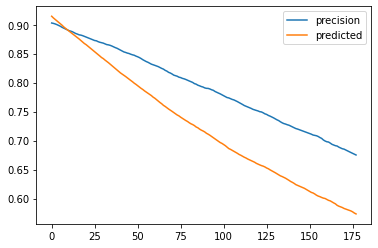

R2:0.0270 +- 0.4431
Trial:2.0000 +- 1.9600
Mean R^2 (sum(r2)/N) : 0.026991429584369463


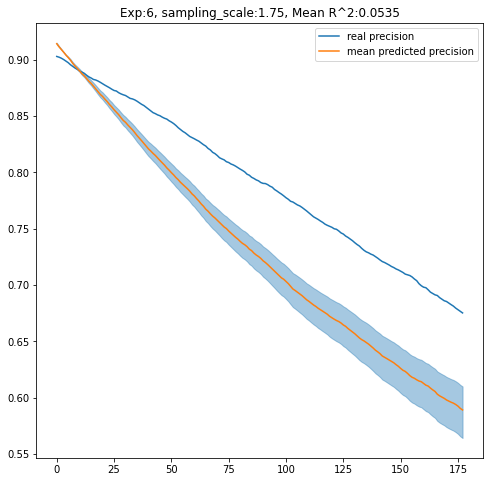

Exp 7, Trial 1
1000/1000 precision:0.9033 drift:0.0228

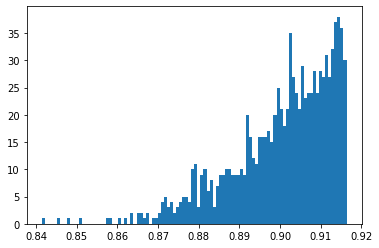

Model R^2: 0.45610602233677733
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     82.94
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          1.81e-123
Time:                        15:30:46   Log-Likelihood:                 3263.0
No. Observations:                1000   AIC:                            -6504.
Df Residuals:                     989   BIC:                            -6450.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2169

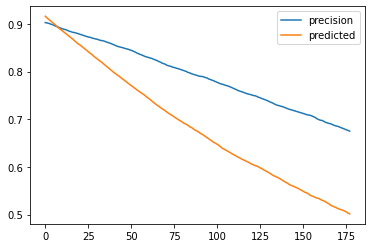

Exp 7, Trial 2
1000/1000 precision:0.8901 drift:0.0214

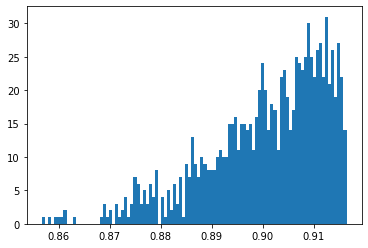

Model R^2: 0.42419133785380847
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     72.86
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          2.39e-111
Time:                        15:34:19   Log-Likelihood:                 3310.6
No. Observations:                1000   AIC:                            -6599.
Df Residuals:                     989   BIC:                            -6545.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1801

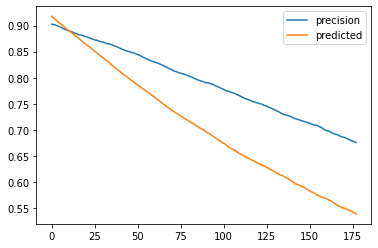

Exp 7, Trial 3
1000/1000 precision:0.8904 drift:0.0216

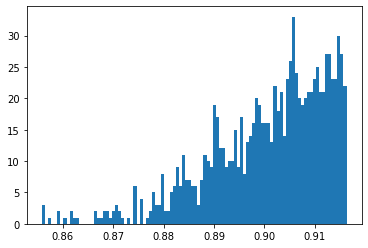

Model R^2: 0.41086673485258396
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     68.97
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          1.72e-106
Time:                        15:37:53   Log-Likelihood:                 3284.6
No. Observations:                1000   AIC:                            -6547.
Df Residuals:                     989   BIC:                            -6493.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2170

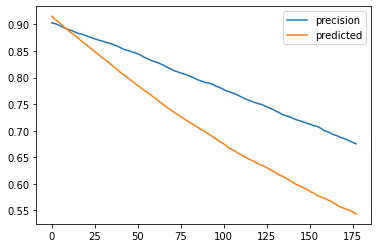

Exp 7, Trial 4
1000/1000 precision:0.9137 drift:0.0123

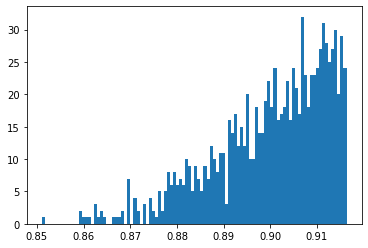

Model R^2: 0.4632851443193309
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     85.37
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          2.70e-126
Time:                        15:41:23   Log-Likelihood:                 3291.3
No. Observations:                1000   AIC:                            -6561.
Df Residuals:                     989   BIC:                            -6507.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3352 

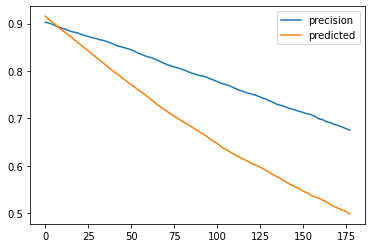

Exp 7, Trial 5
1000/1000 precision:0.8865 drift:0.0247

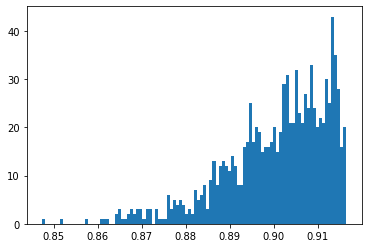

Model R^2: 0.43844459961466786
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     77.22
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          1.13e-116
Time:                        15:44:53   Log-Likelihood:                 3307.8
No. Observations:                1000   AIC:                            -6594.
Df Residuals:                     989   BIC:                            -6540.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2152

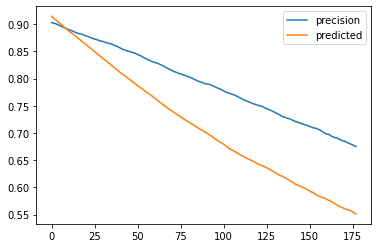

R2:-1.4118 +- 0.9040
Trial:2.0000 +- 1.9600
Mean R^2 (sum(r2)/N) : -1.41181469002958


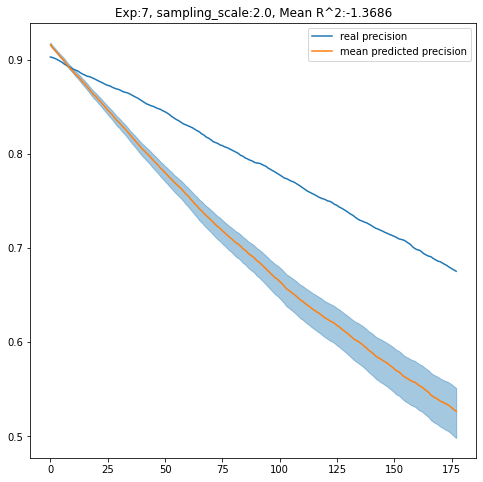

In [143]:
seed_everything()

scales = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
for Exp in range(len(scales)):
    df3 = {}
    result_data = {}
    result_data['R2'] = []
    result_data['Trial'] = []
    #result_dfs = []
    experimant_count = 5
    scale = scales[Exp]
    for trial in range(experimant_count):
        print(f'Exp {Exp+1}, Trial {trial+1}')
        ppmodel,df = ppm_build(scale = scale,epoch =1000)
        R2, result_df = test1(ppmodel)
        #if R2 > -10.0:
        result_data['R2'].append(R2)
        result_data['Trial'].append(trial)
        df3['real precision'] = result_df['precision'].values
        df3[f'predicted {trial}'] = result_df['predicted'].values
        #else:
        #    print('==== Discard this experiment.====')
    if len(result_data) > 0:
        result_visualization(Exp,scale,df3,result_data)

# 결과

<table>
<tr>
<td>Exp</td><td>sample_scale</td><td>성능모델의 학습 R^2</td><td>성능예측 R^2</td>
</tr>
<tr>
<td>1</td><td>0.5</td><td>성능모델의 학습 R^2</td><td>성능예측 R^2</td>

</tr>
</table>